In [8]:
# CAENDigitizerControl - Written by Edgar Mao
#
# Adapted from demo_scope.py by Giovanni Cerretani

In [9]:
import numpy as np

from caen_felib import device, error
import matplotlib.pyplot as plt


In [10]:
# Digitizer settings
# TODO: Figure out if reclen, pre/post-trig are in units of samples or ns


# Configuration parameters
reclen = 2048             # record length, in units of ns
post_trigger = 1024       # ns
trig_edge = f"RISE"       # trigger edge, "RISE" or "FALL"
stmode = f"START_MODE_SW" # Startmodes: "START_MODE_SW", "START_MODE_S_IN", or "START_MODE_FIRST_TRG"


# group-specific settings
gr_on = [0,1,2,3]               # Group numbers to turn on
gr_off = []                     # Group numbers to turn off
gr_trig_lvl = [1100,900,900,900] # in units of LSB (0-4095)
gr_dc = [i/40.96 for i in [840,840,840,840]] # in units of LSB (0-4095)



In [11]:
# Variable for storing all acquired waveforms
allwf = []

# Save the data?
save = True
spath = f"\."

In [12]:
# TODO [Features]:
    # Connectivity and live display [done]
    # Set trigger level [by group], bsline [by group], reclen [done], 
    # Save data [need revising]
    # Basic logic?
    # GUI? or some kind of UI
    # Runtime control
# TODO: clarify settings and delete redudancy (ex. reclen)

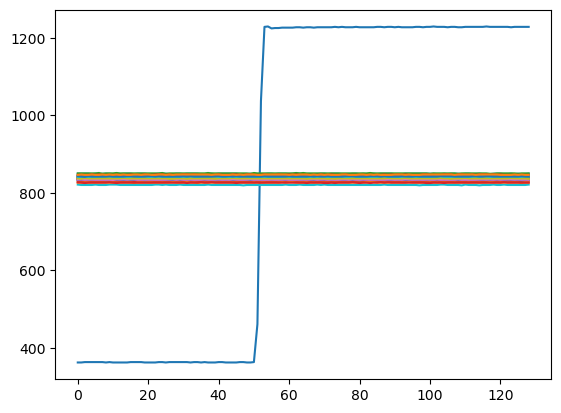

<Figure size 640x480 with 0 Axes>

In [13]:
with device.connect('dig1://caen.internal/usb') as dig:
    # Reset
    dig.cmd.Reset()
    dig.cmd.ClearData()

    
    # Get board info
    nch = int(dig.par.NUMCH.value)
    n_analog_traces = int(dig.par.NUMANALOGTRACES.value)
    n_digital_traces = int(dig.par.NUMDIGITALTRACES.value)
    adc_samplrate_msps = float(dig.par.ADC_SAMPLRATE.value)  # in Msps
    adc_nbit = int(dig.par.ADC_NBIT.value)
    sampling_period_ns = int(1e3 / adc_samplrate_msps)
    fw_type = dig.par.FWTYPE.value


    # Configure digitizer
    dig.par.STARTMODE.value = stmode
    dig.par.RECLEN.value = f'{reclen}'
    dig.par.self_trigger_edge.value = trig_edge
    dig.par.posttrg.value = f'{post_trigger}'

    # Set group parameters
    for i in gr_on:
        dig.group[i].par.gr_enabled.value = f'TRUE'
        dig.group[i].par.gr_threshold.value = f'{gr_trig_lvl[i]}'
        dig.group[i].par.gr_dcoffset.value = f'{gr_dc[i]}'

    
    # Compute record length in samples
    reclen_ns = int(dig.par.RECLEN.value)  # Read back RECLEN to check if there have been rounding
    reclen = int(reclen_ns / sampling_period_ns)


    # Set enabled endpoint to activate decode
    dig.endpoint.par.ActiveEndpoint.value = 'scope'

    # Configure endpoint
    data_format = [
        {
            'name': 'TIMESTAMP',
            'type': 'U64',
        },
        {
            'name': 'WAVEFORM',
            'type': 'U16',
            'dim': 2,
            'shape': [nch, reclen],
        },
        {
            'name': 'WAVEFORM_SIZE',
            'type': 'U64',
            'dim': 1,
            'shape': [nch],
        },
    ]


    # Store endpoint node
    decoded_endpoint_path = fw_type.strip('-')  # decoded endpoint path is just firmware type without -
    endpoint = dig.endpoint[decoded_endpoint_path]
    # set_read_data_format returns allocated buffers
    data = endpoint.set_read_data_format(data_format)

    timestamp = data[0].value
    waveform = data[1].value
    waveform_size = data[2].value
    
    # setup live plot
    fig = plt.figure()
    hfig = display(fig, display_id=True)
    
    # Start acquisition
    dig.cmd.ArmAcquisition()

    # Acquisition loop
    def update():
        # TODO: Add a feature that controls the run time rather than just this for loop
        for _ in range(100):

            # Send trigger
            #dig.cmd.SendSwTrigger()

            # Wait for event
            try:
                dig.endpoint.scope.read_data(0, data)
                allwf.append(waveform)
            except error.Error as ex:
                if ex.code == error.ErrorCode.TIMEOUT:
                    # Timeout expired, waiting again
                    continue
                elif ex.code == error.ErrorCode.STOP:
                    # End of run, exit the loop
                    print('End of run.')
                    break
                else:
                    # Other critical error, propagate it
                    raise ex

            for i in range(nch):
                plt.plot(np.arange(0, waveform_size[i]), waveform[i])

            # Change sampling rate of live plots
            '''
            if _%10:
                for i in range(nch):
                    plt.plot(np.arange(0, waveform_size[i]), waveform[i])
            '''

            fig.canvas.draw()
            hfig.update(fig)
            fig.canvas.flush_events()
            plt.clf()
            
        
    update()

    # Stop acquisition
    dig.cmd.DisarmAcquisition()

In [14]:
# Save data
# Each triggered event is saved as a separate file

for i in range(len(allwf)):
    np.savetxt(f"wf{i}.csv",
            allwf[i],
            delimiter =", ",
            fmt ='% s')

In [34]:
# Note: right now the channels are triggering normally but the buffer is being filled up, for low rate studies (<10Hz) the current live plot feature is fine
# for high rate use cases need to lower the sampling rate of the live plot feature
# TODO: high rate feature, complete setting file, releasable version, trig in